# ISE Cryptography Week 2

These challenges are going to be much easier if you complete the exercises from the lecture first!
You should have working implementations of the Caesar cipher and One-Time Pad, and be comfortable working with bytes in Python before you start.

## TEA Block Cipher

Implement the Tiny Encryption Algorithm (TEA) block cipher. You can find the specification for TEA [here](https://en.wikipedia.org/wiki/Tiny_Encryption_Algorithm).

Remember, the reference implementation uses arrays of 32-bit unsigned integers. The block size is 64 bits, and the key is 128 bits long.

Think about how you can test your implementation. You should be able to encrypt and decrypt a message, and get the original message back.

**Hint:** You can use the `struct` module to convert between bytes and integers in Python really easily. This'll be useful for converting the key and message to the right format for TEA, depending on how you choose to implement it.

**Hint:** Python's integers have no max size. You can use `& 0xffffffff` to keep only the least significant 32 bits of an integer.

**Hint:** You've already got a reference implementation in C. You can use this to test your Python implementation and make sure it's working correctly.

```c
#include <stdint.h>

void encrypt (uint32_t v[2], const uint32_t k[4]) {
    uint32_t v0=v[0], v1=v[1], sum=0, i;           /* set up */
    uint32_t delta=0x9E3779B9;                     /* a key schedule constant */
    uint32_t k0=k[0], k1=k[1], k2=k[2], k3=k[3];   /* cache key */
    for (i=0; i<32; i++) {                         /* basic cycle start */
        sum += delta;
        v0 += ((v1<<4) + k0) ^ (v1 + sum) ^ ((v1>>5) + k1);
        v1 += ((v0<<4) + k2) ^ (v0 + sum) ^ ((v0>>5) + k3);
    }                                              /* end cycle */
    v[0]=v0; v[1]=v1;
}

void decrypt (uint32_t v[2], const uint32_t k[4]) {
    uint32_t v0=v[0], v1=v[1], sum=0xC6EF3720, i;  /* set up; sum is (delta << 5) & 0xFFFFFFFF */
    uint32_t delta=0x9E3779B9;                     /* a key schedule constant */
    uint32_t k0=k[0], k1=k[1], k2=k[2], k3=k[3];   /* cache key */
    for (i=0; i<32; i++) {                         /* basic cycle start */
        v1 -= ((v0<<4) + k2) ^ (v0 + sum) ^ ((v0>>5) + k3);
        v0 -= ((v1<<4) + k0) ^ (v1 + sum) ^ ((v1>>5) + k1);
        sum -= delta;
    }                                              /* end cycle */
    v[0]=v0; v[1]=v1;
}
```

In [6]:
# There are a couple of ways to do this one! We could use Python's int type, or we could use ctypes or numpy's fixed-width ints.
# I'll show you how to do it with Python's int type. Note that bitwise AND with 0xFFFFFFFF is necessary to truncate the result to 32 bits.
# Why 0xFFFFFFFF? Because it's 32 bits of all 1s, so ANDing with it will keep only the last 32 bits of the result.

import secrets
import struct
from typing import Tuple

# Getting fancy with type hints!
TEABlock = Tuple[int, int]
TEAKey = Tuple[int, int, int, int]


# This function is a little helper to truncate an integer to 32 bits.
def uint32(x: int):
    return x & 0xFFFFFFFF


# This function pads the data with null bytes to the next multiple of block_size.
def zero_pad(data: bytes, block_size: int) -> bytes:
    return data + b"\x00" * (block_size - len(data) % block_size)


# These functions convert between Python's bytes type and the 32-bit integers used by TEA.
# We could do this manually, but it's easier to use struct.unpack and struct.pack.
# The "<" means little-endian, and each "I" means a 32-bit unsigned integer.
# TEA's spec doesn't mention endianness, so it's up to you which one you use.

def pack_tea_block(block: TEABlock) -> bytes:
    return struct.pack("<II", *block)


def unpack_tea_block(data: bytes) -> TEABlock:
    return struct.unpack("<II", data)


def unpack_tea_key(data: bytes) -> TEAKey:
    return struct.unpack("<IIII", data)


def tea_encipher_block(v: bytes, k: bytes) -> bytes:
    delta = 0x9E3779B9
    v0, v1 = unpack_tea_block(v)
    k0, k1, k2, k3 = unpack_tea_key(k)
    sum = 0
    for i in range(32):
        sum = uint32(sum + delta)
        v0 = uint32(v0 + (((v1 << 4) + k0) ^ (v1 + sum) ^ ((v1 >> 5) + k1)))
        v1 = uint32(v1 + (((v0 << 4) + k2) ^ (v0 + sum) ^ ((v0 >> 5) + k3)))
    return pack_tea_block((v0, v1))


def tea_decipher_block(v: bytes, k: bytes) -> bytes:
    delta = 0x9E3779B9
    v0, v1 = unpack_tea_block(v)
    k0, k1, k2, k3 = unpack_tea_key(k)
    sum = uint32(delta << 5)
    for i in range(32):
        v1 = uint32(v1 - (((v0 << 4) + k2) ^ (v0 + sum) ^ ((v0 >> 5) + k3)))
        v0 = uint32(v0 - (((v1 << 4) + k0) ^ (v1 + sum) ^ ((v1 >> 5) + k1)))
        sum = uint32(sum - delta)
    return pack_tea_block((v0, v1))

plaintext: b'This is a test.\x00'
ciphertext: b'C\xdf\xe7\xccH\xcc+U\n.I\xf8t\x00\xa7h'
decrypted: b'This is a test.\x00'


## Electronic Codebook (ECB) Mode

Implement the Electronic Codebook (ECB) mode of operation for the TEA block cipher. Divide the plaintext into 64-bit blocks, and encrypt each block separately. Concatenate the ciphertext blocks to form the final ciphertext. Remember to pad the last block if necessary!

You'll need to implement encryption and decryption functions for ECB mode. The encryption function should take a plaintext and a key, and return the ciphertext. The decryption function should take a ciphertext and a key, and return the plaintext.

Think about whether or not you can parallelize the encryption and/or decryption functions. How many blocks can you encrypt or decrypt at the same time? Is random read access feasible, or do you need to read the blocks sequentially?

In [16]:
# ECB mode is the simplest mode of operation. It just encrypts each block independently.
# It's also an unholy nightmare of insecurity, so don't use it in real life!

# Let's keep the block size as a constant, so we don't have to hardcode it everywhere.
TEA_BLOCK_SIZE = 8

def tea_ecb_encrypt(plaintext: bytes, key: bytes) -> bytes:
    ciphertext = b""
    for i in range(0, len(plaintext), TEA_BLOCK_SIZE):
        ciphertext += tea_encipher_block(plaintext[i : i + TEA_BLOCK_SIZE], key)
    return ciphertext


def tea_ecb_decrypt(ciphertext: bytes, key: bytes) -> bytes:
    plaintext = b""
    for i in range(0, len(ciphertext), TEA_BLOCK_SIZE):
        plaintext += tea_decipher_block(ciphertext[i : i + TEA_BLOCK_SIZE], key)
    return plaintext


# It can be handy to keep demos/tests in a separate function, so you can avoid polluting the global namespace!
def test_tea_ecb():
    key = secrets.token_bytes(16)
    plaintext = zero_pad(b"This is a test.", TEA_BLOCK_SIZE)
    ciphertext = tea_ecb_encrypt(plaintext, key)
    decrypted = tea_ecb_decrypt(ciphertext, key)
    print("plaintext:", plaintext)
    print("ciphertext:", ciphertext)
    print("decrypted:", decrypted)


test_tea_ecb()

plaintext: b'This is a test.\x00'
ciphertext: b'\x08g}\x90\xcb\xb3B\x8b\xd3\x89RIFr\xff\xfc'
decrypted: b'This is a test.\x00'


## The Penguin of Doom

Open the file `assets/tux.png` and convert it to a bitmap image before displaying it. You can use the Python Imaging Library (PIL) to do this. You should see an image of the Linux mascot, Tux the penguin.

Encrypt the image using ECB mode with the TEA block cipher. Display the encrypted image. Decrypt the image and display it again. You should see the original image of Tux.

What do you notice about the encrypted image? How does it compare to the original image?

For comparison, try encrypting the image data using your one-time pad implementation. How does the encrypted image compare to the TEA-ECB-encrypted image?

Original image:


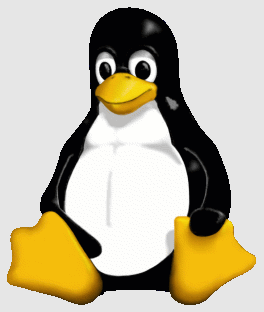

Encrypted image (TEA-ECB):


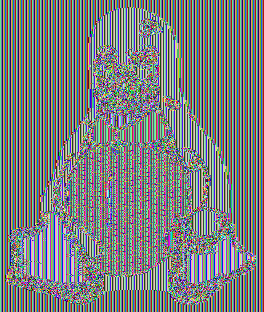

Encrypted image (One-Time Pad):


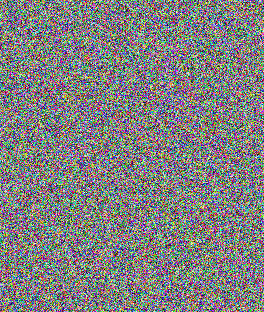

In [15]:
from typing import Tuple
from PIL import Image


def image_to_bytes(image: Image) -> bytes:
    return bytes(image.tobytes("raw", "RGB"))


def bytes_to_image(data: bytes, size: Tuple[int, int]) -> bytes:
    return Image.frombytes("RGB", size, data)


# Read the image and convert it to a bitmap of bytes
tux_image = Image.open("../assets/tux.png")

# Use this raw image data for encryption
tux_image_bytes = image_to_bytes(tux_image)

# Restore the image from the raw data like this
print("Original image:")
display(bytes_to_image(tux_image_bytes, tux_image.size))

# Encrypt the image using TEA-ECB
# The key is regenerated each time, so the image will be different each time...
# ...but you can still see the outline of Tux!
print("Encrypted image (TEA-ECB):")
tea_ecb_tux = tea_ecb_encrypt(tux_image_bytes, secrets.token_bytes(16))
display(bytes_to_image(tea_ecb_tux, tux_image.size))


def one_time_pad_encrypt(plaintext: bytes, key: bytes) -> bytes:
    return bytes(a ^ b for a, b in zip(plaintext, key))


# The one-time pad produces a completely random-looking image, by contrast.
# This is related to the idea of ciphertext indistinguishability and diffusion.
# Note that "looking random" is not the same as "being secure"!
print("Encrypted image (One-Time Pad):")
one_time_pad_tux = one_time_pad_encrypt(
    tux_image_bytes, secrets.token_bytes(len(tux_image_bytes))
)
display(bytes_to_image(one_time_pad_tux, tux_image.size))

## The Penguin of Doom, Part 2

So ECB mode isn't very secure. Implement the Cipher Block Chaining (CBC) mode of operation for the TEA block cipher, detailed [here](https://en.wikipedia.org/wiki/Block_cipher_mode_of_operation#Cipher_block_chaining_(CBC)). You'll need to generate an Initialization Vector (IV) to use with the first block. Remember to XOR the IV with the first plaintext block before encrypting it. Do some research on how to generate a secure IV.

Encrypt the image using CBC mode with the TEA block cipher. Display the encrypted image. Decrypt the image and display it again. You should see the original image of Tux. How does the CBC-encrypted image compare to the ECB-encrypted image?

What happens if you get the IV wrong when decrypting the image? How does the decrypted image compare to the original image? Why is this?

Now think about concurrency again. Can you parallelize the encryption and/or decryption functions? How many blocks can you encrypt or decrypt at the same time? Is random read access feasible, or do you need to read the blocks sequentially?

In [75]:
from typing import List


def xor(a: bytes, b: bytes) -> bytes:
    return bytes(x ^ y for x, y in zip(a, b))


# Let's create a helper function for blocks!
def blocks(data: bytes, block_size: int = TEA_BLOCK_SIZE) -> List[bytes]:
    return [data[i : i + block_size] for i in range(0, len(data), block_size)]


def tea_cbc_encrypt(plaintext: bytes, key: bytes, iv: bytes) -> bytes:
    ciphertext = b""
    prev_ciphertext_block = iv
    for plaintext_block in blocks(plaintext):
        ciphertext_block = tea_encipher_block(
            xor(plaintext_block, prev_ciphertext_block), key
        )
        ciphertext += ciphertext_block
        prev_ciphertext_block = ciphertext_block
    return ciphertext


def tea_cbc_decrypt(ciphertext: bytes, key: bytes, iv: bytes) -> bytes:
    plaintext = b""
    prev_ciphertext_block = iv
    for ciphertext_block in blocks(ciphertext):
        plaintext_block = xor(tea_decipher_block(ciphertext_block, key), prev_ciphertext_block)
        plaintext += plaintext_block
        prev_ciphertext_block = ciphertext_block
    return plaintext


def test_tea_cbc():
    key = secrets.token_bytes(16)
    iv = secrets.token_bytes(TEA_BLOCK_SIZE)
    plaintext = zero_pad(b"This is a test with multiple blocks.", TEA_BLOCK_SIZE)
    ciphertext = tea_cbc_encrypt(plaintext, key, iv)
    decrypted = tea_cbc_decrypt(ciphertext, key, iv)
    print("plaintext:", plaintext)
    print("ciphertext:", ciphertext)
    print("decrypted:", decrypted)


test_tea_cbc()

plaintext: b'This is a test with multiple blocks.\x00\x00\x00\x00'
ciphertext: b"k$@'\xe0\x9c~\xf0\xe0V\xae\xe9X\xb8x\xf1\x80\x0ek\xba\x17](\x832Saq\xb7\xbbp\xb5\n\x8b{\xb7\x9a\xdf\xb7\x0f"
decrypted: b'This is a test with multiple blocks.\x00\x00\x00\x00'


Encrypted image (TEA-CBC):


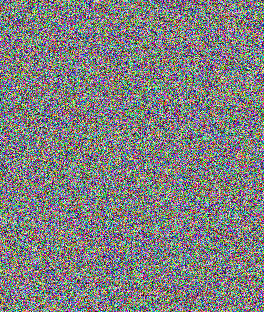

Decrypted image (TEA-CBC):


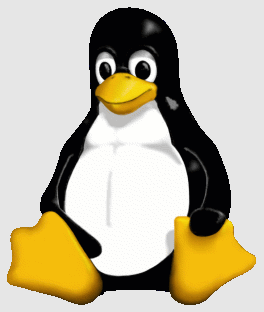

In [77]:
print("Encrypted image (TEA-CBC):")
tea_cbc_key = secrets.token_bytes(16)
tea_cbc_iv = secrets.token_bytes(TEA_BLOCK_SIZE)
tea_ecb_tux = tea_cbc_encrypt(tux_image_bytes, tea_cbc_key, tea_cbc_iv)
display(bytes_to_image(tea_ecb_tux, tux_image.size))

print("Decrypted image (TEA-CBC):")
tea_ecb_tux = tea_cbc_decrypt(tea_ecb_tux, tea_cbc_key, tea_cbc_iv)
display(bytes_to_image(tea_ecb_tux, tux_image.size))

## The Penguin of Doom, Part 3

Research and implement each of the modes of operation below for the TEA block cipher. You should have implemented ECB and CBC modes already!
- Cipher Feedback (CFB)
- Output Feedback (OFB)
- Propagating Cipher Block Chaining (PCBC)

Encrypt the image using your chosen mode of operation with the TEA block cipher. Display the encrypted image. Decrypt the image and display it again. You should see the original image of Tux. How does the encrypted image compare to the ECB- and CBC-encrypted images?

What are the advantages and disadvantages of the mode you chose compared to ECB and CBC?

Pick your favorite mode of operation from this task. Put together a (very) short presentation on the mode, 5 minutes tops, you might be asked to present it to the class next week! This could be a few short slides, or just a few bullet points and some code snippets. The core idea here it to make sure you understand the material well enough to explain it to someone else!

### Cipher Feedback (CFB)

Encrypted image (TEA-CFB):


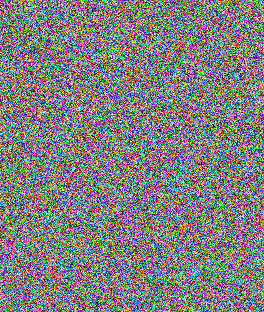

Decrypted image (TEA-CFB):


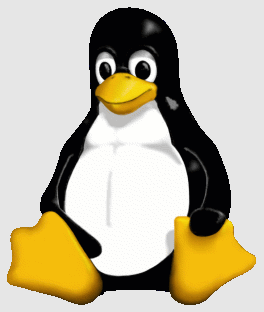

In [64]:
def tea_cfb_encrypt(plaintext: bytes, key: bytes, iv: bytes) -> bytes:
    ciphertext = b""
    prev_ciphertext_block = iv
    for plaintext_block in blocks(plaintext):
        output_block = tea_encipher_block(prev_ciphertext_block, key)
        ciphertext_block = xor(output_block, plaintext_block)
        ciphertext += ciphertext_block
        prev_ciphertext_block = ciphertext_block
    return ciphertext


def tea_cfb_decrypt(ciphertext: bytes, key: bytes, iv: bytes) -> bytes:
    plaintext = b""
    prev_ciphertext_block = iv
    for ciphertext_block in blocks(ciphertext):
        output_block = tea_encipher_block(prev_ciphertext_block, key)
        plaintext_block = xor(output_block, ciphertext_block)
        plaintext += plaintext_block
        prev_ciphertext_block = ciphertext_block
    return plaintext


def test_tea_cfb():
    print("Encrypted image (TEA-CFB):")
    key = secrets.token_bytes(16)
    iv = secrets.token_bytes(TEA_BLOCK_SIZE)
    tux = tea_cfb_encrypt(tux_image_bytes, key, iv)
    display(bytes_to_image(tux, tux_image.size))

    print("Decrypted image (TEA-CFB):")
    tux = tea_cfb_decrypt(tux, key, iv)
    display(bytes_to_image(tux, tux_image.size))


test_tea_cfb()

### Output Feedback (OFB)

Encrypted image (TEA-OFB):


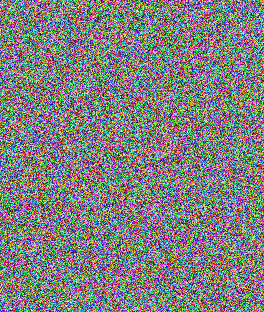

Decrypted image (TEA-OFB):


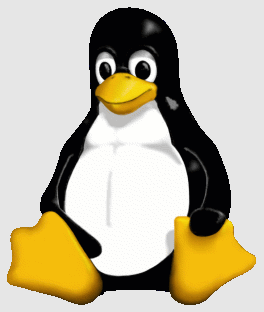

In [63]:
def tea_ofb_encrypt(plaintext: bytes, key: bytes, iv: bytes) -> bytes:
    ciphertext = b""
    prev_output_block = iv
    for plaintext_block in blocks(plaintext):
        output_block = tea_encipher_block(prev_output_block, key)
        ciphertext_block = xor(output_block, plaintext_block)
        ciphertext += ciphertext_block
        prev_output_block = output_block
    return ciphertext


def tea_ofb_decrypt(ciphertext: bytes, key: bytes, iv: bytes) -> bytes:
    plaintext = b""
    prev_output_block = iv
    for ciphertext_block in blocks(ciphertext):
        output_block = tea_encipher_block(prev_output_block, key)
        plaintext_block = xor(output_block, ciphertext_block)
        plaintext += plaintext_block
        prev_output_block = output_block
    return plaintext


def test_tea_ofb():
    print("Encrypted image (TEA-OFB):")
    key = secrets.token_bytes(16)
    iv = secrets.token_bytes(TEA_BLOCK_SIZE)
    tux = tea_ofb_encrypt(tux_image_bytes, key, iv)
    display(bytes_to_image(tux, tux_image.size))

    print("Decrypted image (TEA-OFB):")
    tux = tea_ofb_decrypt(tux, key, iv)
    display(bytes_to_image(tux, tux_image.size))


test_tea_ofb()

### Propagating Cipher Block Chaining (PCBC)

Encrypted image (TEA-PCBC):


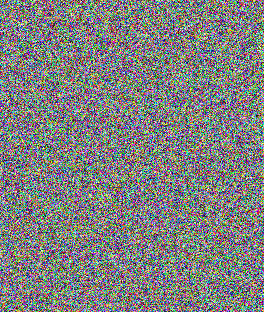

Decrypted image (TEA-PCBC):


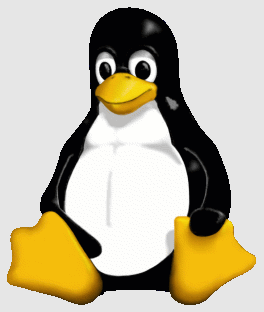

In [67]:
def tea_pcbc_encrypt(plaintext: bytes, key: bytes, iv: bytes) -> bytes:
    ciphertext = b""
    propagation = iv
    for plaintext_block in blocks(plaintext):
        ciphertext_block = tea_encipher_block(xor(propagation, plaintext_block), key)
        ciphertext += ciphertext_block
        propagation = xor(plaintext_block, ciphertext_block)
    return ciphertext


def tea_pcbc_decrypt(ciphertext: bytes, key: bytes, iv: bytes) -> bytes:
    plaintext = b""
    propagation = iv
    for ciphertext_block in blocks(ciphertext):
        plaintext_block = xor(tea_decipher_block(ciphertext_block, key), propagation)
        plaintext += plaintext_block
        propagation = xor(plaintext_block, ciphertext_block)
    return plaintext


def test_tea_pcbc():
    print("Encrypted image (TEA-PCBC):")
    key = secrets.token_bytes(16)
    iv = secrets.token_bytes(TEA_BLOCK_SIZE)
    tux = tea_pcbc_encrypt(tux_image_bytes, key, iv)
    display(bytes_to_image(tux, tux_image.size))

    print("Decrypted image (TEA-PCBC):")
    tux = tea_pcbc_decrypt(tux, key, iv)
    display(bytes_to_image(tux, tux_image.size))


test_tea_pcbc()